In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.2 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding
from transformers import BertTokenizer, TFBertModel, BertForSequenceClassification, AdamW
from tensorflow.keras.optimizers import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch

In [5]:
# Step 1: Load and preprocess the dataset
df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding='latin-1', header=None)
df.columns = ['target', 'id', 'date', 'flag', 'user', 'text']
df = df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataset
df = df.head(635)
df['text'] = df['text'].apply(lambda x: re.sub(r'\@\w+|\#', '', x))  # Remove mentions and hashtags
df['target'] = df['target'].replace(4,1)

In [6]:
df.head(6)
df.target.value_counts()

1    327
0    308
Name: target, dtype: int64

In [7]:
# Step 2: Split the dataset into training and testing sets
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Step 3: Naive Bayes
vectorizer = CountVectorizer()
X_train_nb = vectorizer.fit_transform(X_train)
X_test_nb = vectorizer.transform(X_test)
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_nb, y_train)
y_pred_nb = naive_bayes.predict(X_test_nb)

In [9]:
nb_accuracy = accuracy_score(y_test, y_pred_nb)
nb_precision = precision_score(y_test, y_pred_nb)
nb_recall = recall_score(y_test, y_pred_nb)
nb_f1 = f1_score(y_test, y_pred_nb)

In [10]:
print("Naive Bayes:")
print("Accuracy:", nb_accuracy)
print("Precision:", nb_precision)
print("Recall:", nb_recall)
print("F1-score:", nb_f1)
print()

Naive Bayes:
Accuracy: 0.6850393700787402
Precision: 0.7333333333333333
Recall: 0.6470588235294118
F1-score: 0.6875



In [11]:
# Step 4: SVM
tfidf_vectorizer = TfidfVectorizer()
X_train_svm = tfidf_vectorizer.fit_transform(X_train)
X_test_svm = tfidf_vectorizer.transform(X_test)
svm_classifier = svm.SVC()
svm_classifier.fit(X_train_svm, y_train)
y_pred_svm = svm_classifier.predict(X_test_svm)

In [12]:
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_precision = precision_score(y_test, y_pred_svm)
svm_recall = recall_score(y_test, y_pred_svm)
svm_f1 = f1_score(y_test, y_pred_svm)

In [13]:
print("SVM:")
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1-score:", svm_f1)
print()

SVM:
Accuracy: 0.6614173228346457
Precision: 0.6712328767123288
Recall: 0.7205882352941176
F1-score: 0.6950354609929077



In [14]:
# Step 5: BI-LSTM with Word2Vec
word2vec_model = Word2Vec(sentences=X_train.apply(lambda x: x.split()), vector_size=100, min_count=1)
word2vec_model.train(X_train.apply(lambda x: x.split()), total_examples=word2vec_model.corpus_count, epochs=10)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

X_train_lstm = tokenizer.texts_to_sequences(X_train)
X_test_lstm = tokenizer.texts_to_sequences(X_test)
X_train_lstm = pad_sequences(X_train_lstm, maxlen=100)
X_test_lstm = pad_sequences(X_test_lstm, maxlen=100)

model_lstm = Sequential()
model_lstm.add(Embedding(vocab_size, 100, weights=[embedding_matrix[:vocab_size]], input_length=100, trainable=False))
model_lstm.add(Bidirectional(LSTM(64, return_sequences=True)))
model_lstm.add(Bidirectional(LSTM(32)))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(X_train_lstm, y_train, validation_data=(X_test_lstm, y_test), epochs=5, batch_size=64)
y_pred_lstm = model_lstm.predict(X_test_lstm)

Epoch 1/5
8/8 [==============================] - 25s 332ms/step - loss: 0.6927 - accuracy: 0.5197 - val_loss: 0.6884 - val_accuracy: 0.6063
Epoch 2/5
8/8 [==============================] - 0s 33ms/step - loss: 0.6898 - accuracy: 0.5256 - val_loss: 0.6866 - val_accuracy: 0.5906
Epoch 3/5
8/8 [==============================] - 0s 24ms/step - loss: 0.6853 - accuracy: 0.5650 - val_loss: 0.6906 - val_accuracy: 0.5748
Epoch 4/5
8/8 [==============================] - 0s 21ms/step - loss: 0.6887 - accuracy: 0.5591 - val_loss: 0.6888 - val_accuracy: 0.5906
Epoch 5/5
4/4 [==============================] - 3s 13ms/step


In [15]:
y_pred_lstm = np.where(y_pred_lstm >= 0.5, 1, 0)
lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
lstm_precision = precision_score(y_test, y_pred_lstm)
lstm_recall = recall_score(y_test, y_pred_lstm)
lstm_f1 = f1_score(y_test, y_pred_lstm)

In [16]:
# Print the results
print("BI-LSTM with Word2Vec:")
print("Accuracy:", lstm_accuracy)
print("Precision:", lstm_precision)
print("Recall:", lstm_recall)
print("F1-score:", lstm_f1)
print()

BI-LSTM with Word2Vec:
Accuracy: 0.5118110236220472
Precision: 0.5319148936170213
Recall: 0.7352941176470589
F1-score: 0.617283950617284



In [17]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, return_tensors='pt')
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, return_tensors='pt')
train_labels = torch.tensor(y_train.values).unsqueeze(1)
test_labels = torch.tensor(y_test.values).unsqueeze(1)
train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

# Step 4: Define the BERT-based model and optimizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
optimizer = AdamW(model.parameters(), lr=1e-5)

# Step 5: Create data loaders for training and testing
batch_size = 16

train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)

# Step 6: Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)

    print(f'Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss}')

# Step 7: Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()

    label_ids = inputs['labels'].cpu().numpy()
    predictions.extend(logits.argmax(axis=1))
    true_labels.extend(label_ids)

# Step 8: Calculate evaluation metrics
bert_accuracy = accuracy_score(true_labels, predictions)
bert_precision = precision_score(true_labels, predictions)
bert_recall = recall_score(true_labels, predictions)
bert_f1 = f1_score(true_labels, predictions)

# Step 9: Print evaluation metrics
print("Transformer-based model with BERT-based word embedding:")
print("Accuracy:", bert_accuracy)
print("Precision:", bert_precision)
print("Recall:", bert_recall)
print("F1-score:", bert_f1)
print()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/3, Training Loss: 0.6838094890117645
Epoch 2/3, Training Loss: 0.5897474670782685
Epoch 3/3, Training Loss: 0.42552354745566845
Transformer-based model with BERT-based word embedding:
Accuracy: 0.8031496062992126
Precision: 0.9387755102040817
Recall: 0.6764705882352942
F1-score: 0.7863247863247864



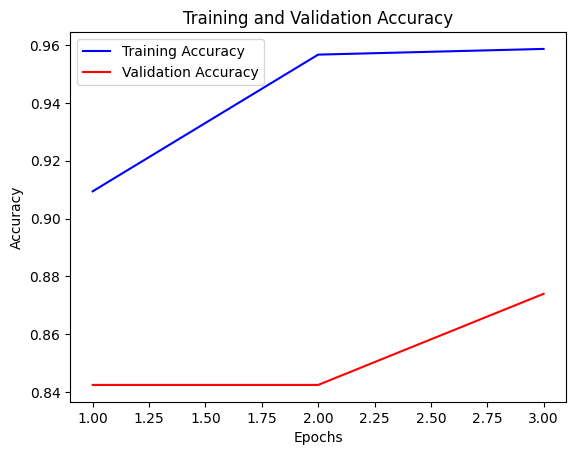

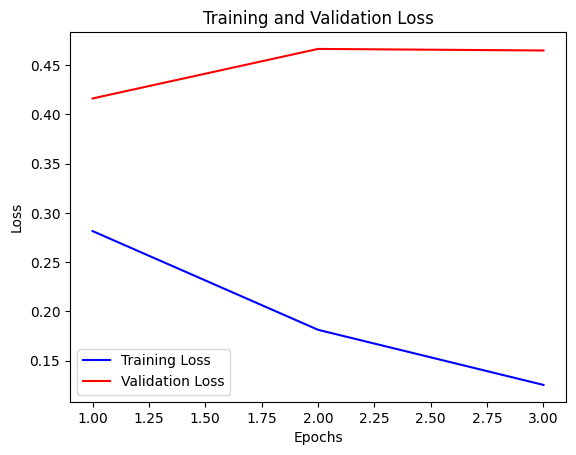

In [18]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss from the training history
epochs = range(1, epochs+1)
train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(3):
    model.train()
    total_loss = 0
    total_correct = 0
    total_examples = 0

    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

        optimizer.zero_grad()
        outputs = model(**inputs)
        loss = outputs.loss
        total_loss += loss.item()

        logits = outputs.logits
        predicted_labels = logits.argmax(dim=1)
        total_correct += (predicted_labels == inputs['labels'].squeeze()).sum().item()
        total_examples += inputs['labels'].size(0)

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_accuracy = total_correct / total_examples

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_examples = 0

    with torch.no_grad():
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0], 'attention_mask': batch[1], 'labels': batch[2]}

            outputs = model(**inputs)
            loss = outputs.loss
            total_val_loss += loss.item()

            logits = outputs.logits
            predicted_labels = logits.argmax(dim=1)
            total_val_correct += (predicted_labels == inputs['labels'].squeeze()).sum().item()
            total_val_examples += inputs['labels'].size(0)

    avg_val_loss = total_val_loss / len(test_dataloader)
    val_accuracy = total_val_correct / total_val_examples

    train_loss.append(avg_train_loss)
    train_acc.append(train_accuracy)
    val_loss.append(avg_val_loss)
    val_acc.append(val_accuracy)

# Plot Training and Validation Accuracy
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Training and Validation Loss
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [19]:
from sklearn.ensemble import RandomForestClassifier

# Step 3: Random Forest
vectorizer = CountVectorizer()
X_train_rf = vectorizer.fit_transform(X_train)
X_test_rf = vectorizer.transform(X_test)

random_forest = RandomForestClassifier()
random_forest.fit(X_train_rf, y_train)
y_pred_rf = random_forest.predict(X_test_rf)

In [20]:
# Calculate evaluation metrics for Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)

# Print evaluation metrics for Random Forest
print("Random Forest:")
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1-score:", rf_f1)
print()

Random Forest:
Accuracy: 0.6692913385826772
Precision: 0.6547619047619048
Recall: 0.8088235294117647
F1-score: 0.7236842105263157



In [21]:
from sklearn.tree import DecisionTreeClassifier

# Step 3: Decision Tree
vectorizer = CountVectorizer()
X_train_dt = vectorizer.fit_transform(X_train)
X_test_dt = vectorizer.transform(X_test)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_dt, y_train)
y_pred_dt = decision_tree.predict(X_test_dt)


In [22]:
# Calculate evaluation metrics for Decision Tree
dt_accuracy = accuracy_score(y_test, y_pred_dt)
dt_precision = precision_score(y_test, y_pred_dt)
dt_recall = recall_score(y_test, y_pred_dt)
dt_f1 = f1_score(y_test, y_pred_dt)

# Print evaluation metrics for Decision Tree
print("Decision Tree:")
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1-score:", dt_f1)
print()

Decision Tree:
Accuracy: 0.5669291338582677
Precision: 0.6031746031746031
Recall: 0.5588235294117647
F1-score: 0.5801526717557252



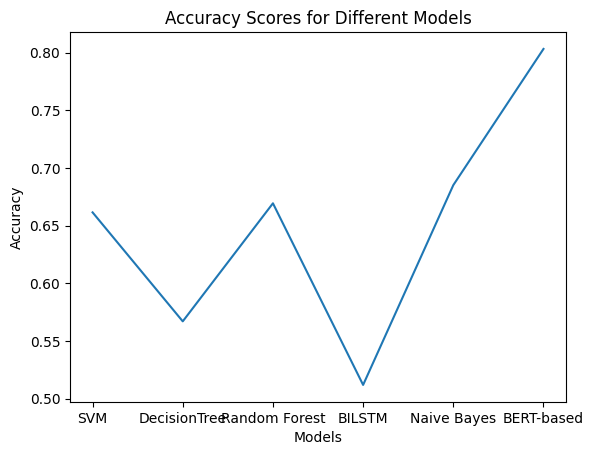

In [23]:
import matplotlib.pyplot as plt

model_names = ['SVM', 'DecisionTree','Random Forest','BILSTM','Naive Bayes','BERT-based']
accuracy_scores = [svm_accuracy,dt_accuracy,rf_accuracy,lstm_accuracy,nb_accuracy,bert_accuracy]

# Set the x-axis positions for the bars
x = range(len(model_names))

# Create a bar plot
plt.plot(x, accuracy_scores)

# Add x-axis labels, y-axis label, and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Accuracy Scores for Different Models')

# Add model names as x-axis tick labels
plt.xticks(x, model_names)

# Display the plot
plt.show()